<a href="https://colab.research.google.com/github/dovahkiin0022/cGAN_demo_HEAs/blob/main/cGAN_Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install necessary modules

In [1]:
!pip install pymatgen
!pip install pymongo[srv]
!pip install wget

     |████████████████████████████████| 40.6 MB 2.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 109 kB 53.9 MB/s 
     |████████████████████████████████| 292 kB 41.5 MB/s 
     |████████████████████████████████| 65 kB 1.9 MB/s 
     |████████████████████████████████| 26.5 MB 1.5 MB/s 
     |████████████████████████████████| 98 kB 6.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 546 kB 65.8 MB/s 
  Created wheel for pymatgen: filename=pymatgen-2022.0.17-cp37-cp37m-linux_x86_64.whl size=41840998 sha256=8431d215faccb90a3945369a06feffe5987404f52ecc3406781f49781c0e0bae
  Stored in directory: /root/.cache/pip/wheels/cf/f6/22/58a9be23c5f1b452770e02ff42047175eaf0f9c2f15219f

     |████████████████████████████████| 241 kB 19.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=bbaeb66ab0fecb35787f93a207dad5f34c206936b7bed4c3a815c1674d7317cb
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


##Make necessary imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pymatgen
from pymatgen import core
import pandas as pd

from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
import math

##Some helpful functions and classes

In [3]:
class data_generator(object):
  """ Creates a generator object from the compositions provided"""
  def __init__(self, comps):
        all_eles = []
        for c in comps:
            all_eles += list(c.get_el_amt_dict().keys())
        all_eles += ['O']
        eles = np.array(sorted(list(set(all_eles))))

        self.elements = eles
        self.size = len(eles)
        self.length = len(comps)

        all_vecs = np.zeros([len(comps), len(self.elements)])
        for i, c in enumerate(comps):
            for k, v in c.get_el_amt_dict().items():
                j = np.argwhere(eles == k)
                all_vecs[i, j] = v
        all_vecs = all_vecs / np.sum(all_vecs, axis=1).reshape(-1, 1)
        self.real_data = np.array(all_vecs, dtype=np.float32)

  def sample(self, N):
      """ Randomly sample compositions"""
      idx = np.random.choice(np.arange(self.length), N, replace=False)
      data = self.real_data[idx]

      return np.array(data, dtype=np.float32),idx
    
  def elements(self):
      """ Return all the elements present in the dataset"""
      return eles

In [4]:
def noise_sampler(N, z_dim):
  """ Draw a noisy array from a normally distributed space """
  return np.random.normal(size=[N, z_dim]).astype('float32')

In [5]:
def decode(vec, thresh=0.0):
    """ Creates a PyMatgen type composition object from a numpy array using elements present in the dataset """
    comp = ''
    for i, x in enumerate(vec):
        if x > thresh:
            comp += dset.elements[i] + '{:.2f} '.format(x)
    return core.Composition(comp)

In [6]:
import json
#import pymatgen as mg
import pandas as pd
#import math
from collections import defaultdict
import os

excelFile = 'https://drive.google.com/uc?id=1GnLqcg5GlHK6lh5pLbUv3Sui8J8imMQC&export=download'
metaDF = pd.read_excel(excelFile)
meta = metaDF.to_json(orient="split")
metaIndex = json.loads(meta)['columns']
metaParsed = json.loads(meta)['data']
meta_dict=defaultdict(dict)

def structure_choose(metaIndex_dict,meta_dict,material,n_index):
    metaIndex_update1={}
    for j,k in metaIndex_dict.items():
        comb_final=0
        data={}
        comb=0
        sum_comb=0
        if k>2:
            for o in material['compositionDictionary'].keys():
                if o not in meta_dict:
                    data[j] = None
                    break

                structure = ''
                if n_index != None:
                    s = n_index
                    structure = material['structure'][s]
                else:
                    try:
                        for a in meta_dict[o].keys():
                            int(a)
                            structure = meta_dict[o][a][1]
                    except:
                        structure='BCC'
                    #print('strucutre',material['compositionDictionary'],o,structure)

                try:
                    data[j]=meta_dict[o][structure][k]
                    float(data[j])
                    ##print('BCC')
                except:
                    ##print('No vaule for '+j+' of '+o+' for the phase in records, try other structures')
                    if structure=='BCC':
                        try:
                            data[j]=meta_dict[o]['FCC'][k]
                            float(data[j])
                            ##print('FCC')
                        except:
                            try:
                                data[j]=meta_dict[o]['HCP'][k]
                                float(data[j])
                                ##print('HCP')
                            except:
                                ##print('BREAk')
                                data[j] = None
                                break
    
                    elif structure=='FCC':
                        try:
                            data[j]=meta_dict[o]['HCP'][k]
                            float(data[j])
                        except:
                            try:
                                data[j]=meta_dict[o]['BCC'][k]
                                float(data[j])
                            except:
                                data[j] = None
                                break
                    elif structure=='HCP':
                        try:
                            data[j]=meta_dict[o]['FCC'][k]
                            float(data[j])
                        except:
                            try:
                                data[j]=meta_dict[o]['BCC'][k]
                                float(data[j])
                            except:
                                data[j] = None
                                break
                    elif structure=='Others':
                        try:
                            data[j]=meta_dict[o]['BCC'][k]
                            float(data[j])
                            #print('others','BCC')
                        except:
                            try:
                                data[j]=meta_dict[o]['FCC'][k]
                                float(data[j])
                                #print('others','FCC')
                            except:
                                try:
                                    data[j]=meta_dict[o]['HCP'][k]
                                    float(data[j])
                                    #print('others','HCP')
                                except:
                                    data[j] = None
                                    break
                

                ##print('data',comb,i['material']['compositionDictionary'][o])
                comb=comb+material['compositionDictionary'][o]*data[j]
                
                sum_comb=sum_comb+material['compositionDictionary'][o]
                        
            if data[j] != None:
                metaIndex_update1[j] = round(float(comb/sum_comb),6)
            else:
                metaIndex_update1[j] = None

    ##print(metaIndex_update1)
    return metaIndex_update1

def structure_calculate(metaIndex_dict,meta_dict,material):
    all_structure=['BCC','FCC','HCP']
    result=[]
    n = 0
    n_index=[]
    try:
        for i in range(len(material['structure'])):
            if material['structure'][i] in all_structure:
                n=n+1
                n_index.append(i) 
        #print('n and st',n)
    except:
        pass
    if n>1:
        #print('n_value',material['formula'],material['structure'][n_index[0]])
        for s in n_index:
            singleResult = structure_choose(metaIndex_dict,meta_dict,material,s)
            singleResult['structure'] = material['structure'][s]
            result.append(singleResult)
    elif n==1:
        #print('n_value1',material['formula'],material['structure'][n_index[0]])
        singleResult = structure_choose(metaIndex_dict,meta_dict,material,n_index[0])
        singleResult['structure'] = material['structure'][n_index[0]]
        result.append(singleResult)
    elif n==0:
        #print('n_value0',material['formula'])
        singleResult = structure_choose(metaIndex_dict, meta_dict, material, None)
        singleResult['structure'] = '?'
        result.append(singleResult)
    ##print(metaIndex_update)
    return result


def linear_combination_run(data):
    
    metaIndex_dict={}
    for k in metaParsed:
        meta_dict[k[2]][k[0]]=k
    ##print(metaIndex,meta_dict)
    for j in range(len(metaIndex)):
        metaIndex_dict[metaIndex[j]] = j
    result = structure_calculate(metaIndex_dict,meta_dict,data['material'])
    return result

In [7]:
def FT_Rice_92(Shear_Modulus,Unstable_Stacking_Fault_Energy,Poisson_Ratio ):
    if None in [Unstable_Stacking_Fault_Energy, Shear_Modulus, Poisson_Ratio]:
        return None
    else:
        return math.sqrt(2*Shear_Modulus*Unstable_Stacking_Fault_Energy/(1-Poisson_Ratio))

In [8]:
def get_sm_ft_vals(compositions):
  """ get the shear modulus and fracture toughness values from compositions in Pymatgen format"""
  ft_val_list = []
  sm_val_list = []
  ks = {}
  for i in range(len(compositions)):
    temp = {}
    temp['formula'] = compositions[i].formula
    temp['compositionDictionary']=compositions[i].as_dict()
    temp['reducedFormula']= compositions[i].reduced_formula
    temp['structure']=['?']
    ks['material']=temp
    LCR = linear_combination_run(ks)
    ft_val = FT_Rice_92(LCR[0]['DFTGh'],LCR[0]['USFE'],LCR[0]['DFTpoisson'])
    ft_val_list.append(ft_val)
    sm_val_list.append(LCR[0]['DFTGh'])
  return sm_val_list,ft_val_list

In [9]:
if torch.cuda.is_available():
    cuda = True
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    cuda = False

##Visualization functions

In [10]:
def fig_plot(points, dset, thresh=0.03):

    fig, axes = plt.subplots(1, 4, figsize=(25, 5))
    ax=axes[0]
    ax.violinplot(points, np.arange(points.shape[1]))
    ax.set_xticks(np.arange(dset.size))
    ax.set_xticklabels(dset.elements,rotation=45)
    ax.set_xlabel('Elements')
    ax.set_ylabel('Frequency')
    s = points.sum(axis=1)
    ax=axes[1]
    if np.max(s) - np.min(s) < 0.1:
        ax.hist(s, np.linspace(0.9, 1.1, 6))
    else:
        ax.hist(s)
    ax.set_xlabel('Sum of fractions')
    ax.set_ylabel('Frequency')
    ax = axes[2]
    ax.hist(points.flatten())
    ax.set_xlabel('Elemental fraction')
    ax.set_ylabel('Frequency')
    ne = (points > thresh).sum(axis=1)
    ax = axes[3]
    ax.hist(ne, np.arange(0, 17), width=0.80)
    ax.set_xlabel('Number of elements')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    plt.close()

## Download CSV file containing data

In [11]:
filename = 'https://drive.google.com/uc?id=1-2Ia30pDDiRgof0FFinN4EQ-1BN24qld&export=download'
df = pd.read_csv(filename,index_col=0)

In [12]:
df

,Composition,Shear modulus,Fracture toughness
0,Be5.5 Ti10.5 Mo10.5 Cr10.5 Fe10.5 Co10.5 Ni10....,58.825500,10.604205
1,Cr14.3 Fe14.3 Co14.3 Ni14.3 Al42.8,54.499199,9.250585
2,Cr1 Mn1 Fe1 Co1 Ni1,75.519997,11.330024
3,Cr20 Mn20 Fe20 Co20 Ni21,75.500992,11.299732
4,Cr10 Mn10 Fe10 Co10 Ni11,75.482353,11.269974
...,...,...,...
524,Hf0.9 Mo91,19.804789,21.160252
525,Hf1.5 Mo98.5,19.860500,21.074387
526,Hf3 Mo97,20.021000,20.826691
527,Hf0.1 Ti0.5 Ta5 W5 Mo1 Cr4 Re4 Ru4 Ni70.3 Al6 ...,81.609200,10.414715


In [13]:
comps = [core.Composition(x) for x in df['Composition']]
prop_vals = df.iloc[:,1:].values.astype('float32')

Scale property values using StandardScaler

In [14]:
scaler = StandardScaler()
prop_vals_scaled = scaler.fit_transform(prop_vals)

Do a Kernel Density Estimation for creating a probability distribution of the property values for sampling

In [15]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
v = kde.fit(prop_vals_scaled)
kde.sample(10) #samples 10 property values using the probability distribution of the properties

array([[-0.00864294, -0.85449818],
       [-1.06239816, -1.07248437],
       [-0.54777862, -0.41200514],
       [ 0.2362336 , -0.36985   ],
       [-0.3752301 , -1.70450298],
       [ 1.20776892,  2.19146167],
       [-1.56371746, -1.61918687],
       [ 0.84893516,  0.17991864],
       [-1.20527   , -0.99956008],
       [-1.24222617, -1.38597045]])

Create data_generator object for randomly sampling vectorized compositions from dataset 

In [ ]:
dset = data_generator(comps)
dset.sample(10) #samples 10 compositions from the dataset (remider : sample returns compositions + its index in dataset)

##GAN architecture

In [19]:
###### MODELS: Generator model and discriminator model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        self.mapf = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.activation_fn = torch.nn.LeakyReLU()
        
    def forward(self, x, property):
        x = torch.cat([x,property],1)
        x = self.activation_fn(self.map1(x))
        x = self.dropout(x)
        x = self.activation_fn(self.map2(x))
        x = self.dropout(x)
        x = self.activation_fn(self.map3(x))
        x = self.dropout(x)
        x = self.activation_fn(self.map4(x))
        x = self.dropout(x)
        x = torch.nn.Softmax(dim=-1)(self.mapf(x))
        x = torch.nn.Threshold(0.04,1e-12)(x)
        return x/x.sum(axis=1).reshape(-1,1)


class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        self.map5 = nn.Linear(hidden_size, hidden_size)
        self.map6 = nn.Linear(hidden_size, hidden_size)
        self.mapf = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.activation_fn = torch.nn.LeakyReLU()

    def forward(self, x, property):
        x = torch.cat([x,property],1)
        x = self.activation_fn(self.map1(x))
        x = self.activation_fn(self.map2(x))
        x = self.activation_fn(self.map3(x))
        x = self.activation_fn(self.map4(x))
        return self.mapf(x)  # for classifier (Wasserstein)
    
    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()  

TODO : Load the joblib model and print the architecture

In [28]:
import wget
generator_path = 'https://drive.google.com/uc?id=1-4TkRTVdk2nlJmfzha_veJ-6vAZy9Nif&export=download'
critic_path = 'https://drive.google.com/uc?id=1-7OWsI6XIXpFc8254LBYwj_lH9TGjMwx&export=download'

gen_file = wget.download(generator_path)
crit_file = wget.download(critic_path)

In [30]:
import joblib

G = joblib.load(gen_file)
D = joblib.load(crit_file)

In [31]:
print(G)

Generator(
  (map1): Linear(in_features=18, out_features=32, bias=True)
  (map2): Linear(in_features=32, out_features=32, bias=True)
  (map3): Linear(in_features=32, out_features=32, bias=True)
  (map4): Linear(in_features=32, out_features=32, bias=True)
  (mapf): Linear(in_features=32, out_features=21, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation_fn): LeakyReLU(negative_slope=0.01)
)


In [32]:
print(D)

Discriminator(
  (map1): Linear(in_features=23, out_features=32, bias=True)
  (map2): Linear(in_features=32, out_features=32, bias=True)
  (map3): Linear(in_features=32, out_features=32, bias=True)
  (map4): Linear(in_features=32, out_features=32, bias=True)
  (map5): Linear(in_features=32, out_features=32, bias=True)
  (map6): Linear(in_features=32, out_features=32, bias=True)
  (mapf): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation_fn): LeakyReLU(negative_slope=0.01)
)


TEST : check if generator can generate comps (NOTE - Use 16 as the size of the latent code, 2 as the size of the property code)

In [ ]:
N_samples = 1000
gen_input = torch.from_numpy(noise_sampler(N_samples, 16))
prop_input = torch.from_numpy(kde.sample(N_samples).astype('float32'))
if cuda:
    gen_input = gen_input.cuda()
    prop_input = prop_input.cuda()
g_fake_data = G(gen_input,prop_input).to('cpu').detach().numpy()

TEST : check how the generated compositions look using the decode function

In [ ]:
[decode(x) for x in g_fake_data]

TEST : Visually examine the statistics from the compositions

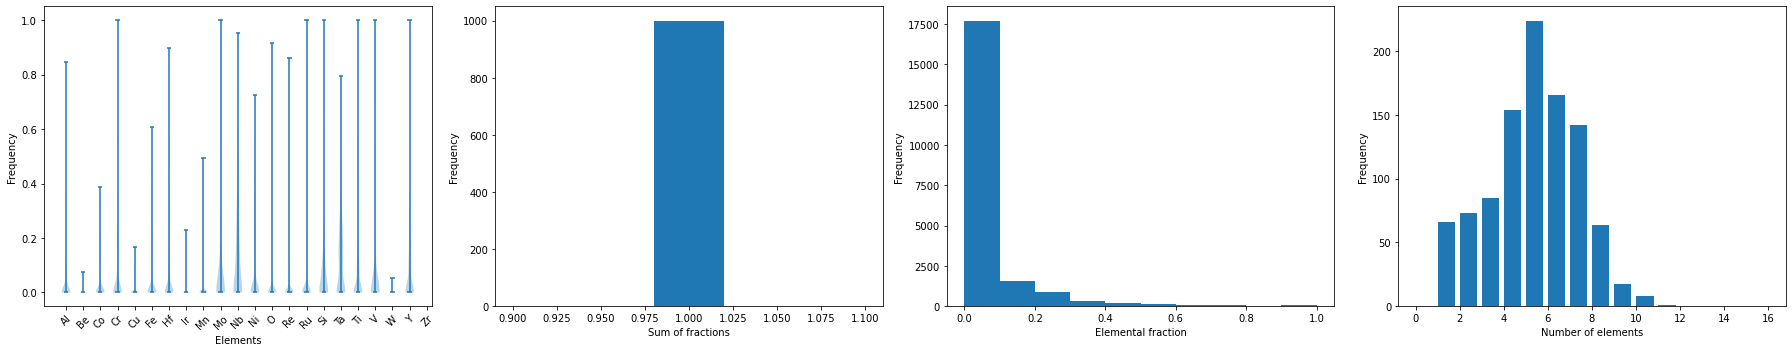

In [ ]:
fig_plot(g_fake_data)

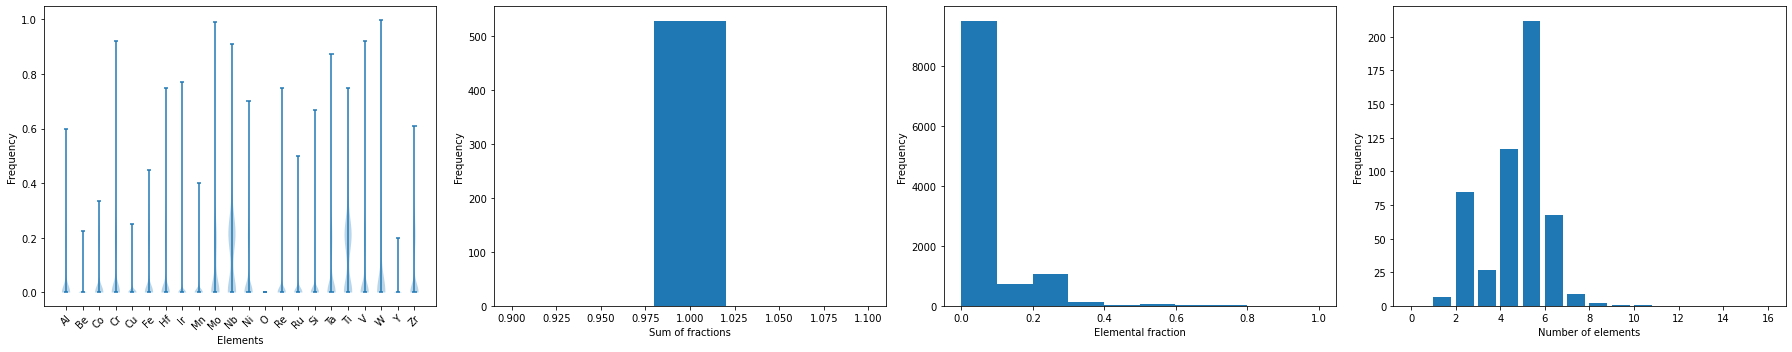

In [ ]:
fig_plot(dset.real_data)

##Sampling from latent space

EXAMPLE : Use a fixed conditioning value to generate 10 compositions

In [ ]:
fixed_cond = torch.from_numpy((np.ones((10,2))*kde.sample(1)).astype('float32'))

In [ ]:
latent_code = torch.from_numpy(noise_sampler(10,16).astype('float32'))
if cuda:
    latent_code = latent_code.cuda()
    fixed_cond = fixed_cond.cuda()
g_fake_data = G(latent_code,fixed_cond).to('cpu').detach().numpy()
decoded = [decode(x) for x in g_fake_data]

In [ ]:
decoded

[Comp: Al0.05 Cr0.07 Fe0.22 Co0.22 Ni0.45,
 Comp: Ta0.24 Nb0.17 Al0.1 Cr0.07 Fe0.06 Co0.08 Cu0.09 Si0.05 Ni0.14,
 Comp: Mn0.16 Al0.05 Fe0.26 Cu0.1 Ni0.24 Ru0.18,
 Comp: Ta0.06 Ti0.16 Al0.08 Cr0.19 Fe0.11 Co0.22 Ni0.18,
 Comp: Ta0.36 Mn0.06 Al0.06 Cr0.06 Fe0.09 Co0.23 Ni0.14,
 Comp: Cr0.16 Fe0.29 Co0.26 Ni0.29,
 Comp: Al0.15 Cr0.18 Fe0.22 Co0.17 Ni0.28,
 Comp: Al0.19 Cr0.19 Fe0.2 Co0.17 Ni0.25,
 Comp: Ta0.53 Nb0.11 Re0.15 Si0.05 Ir0.07 Ru0.08,
 Comp: Mn0.06 Al0.07 Cr0.14 Fe0.23 Co0.22 Cu0.06 Ni0.21]

EXAMPLE : Get the property values of the generated compositions from the surrogate model

In [ ]:
get_sm_ft_vals(decoded)

([86.477344,
  57.108328,
  96.516726,
  71.083109,
  75.331977,
  86.704535,
  75.557567,
  72.711684,
  94.836577,
  79.242461],
 [10.794959488950598,
  9.604588458145106,
  10.90963042123352,
  10.769704991974761,
  10.76941054547566,
  12.516039542901396,
  11.527211690296943,
  11.304537237732903,
  12.898635949381578,
  11.285791332506646])

TO_TRY : 
1. Use normal distribution sampling and uniform distribution sampling for conditioning vector
2. Take some fixed conditions (using joint probability distribution) and generate compositions. 
3. Do this for individual probability distributions


TO_TRY : Take a fixed latent code, and use some (10-20?) different conditioning cases - visualize the changes in the generated outcome